### ロジスティック写像  
#### やったこと  

1\. カオスの時の予測  
10点のデータから次の1点を予測した(LSTMを用いた)  
予測したデータを用いて次の点を予測した  
xの初期値は0.1234  
aは3.82  
これらの値はwikipediaでカオスの出現の例として使用している値を用いた



In [1]:
##ロジスティック写像のデータ作成
#ロジスティック写像の漸化式
#y = ax(1-X)


インポート

In [2]:
#各種のインポート
import torch
from torch import nn,optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary #torchinfoはニューラルネットの中身を見れるのでおすすめ
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import random

#乱数固定用の処理
seed = 10
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


とりあえず100個のデータを作る

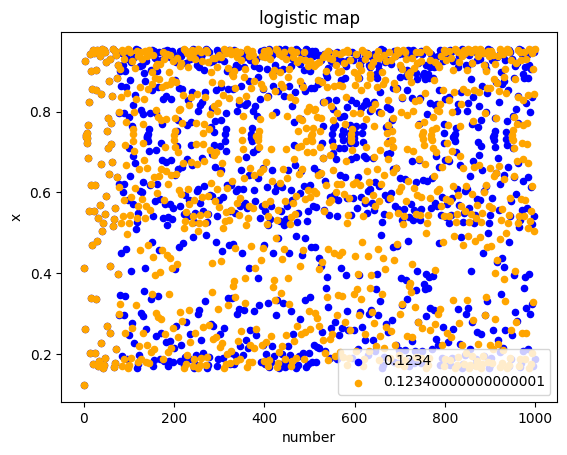

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

x_data = []
y_data = [] #ここにデータを入れていく
x_init = 0.1234  #xの初期値
x_data.append(x_init)
a = 3.82          #aの値を設定
n = 1000        #n個データを作る
def function(x):    #ロジスティック写像
    y = a*x*(1-x)
    return y
for i in range(n):
    y = function(x_data[-1])
    y_data.append(y)
    if i == n-1:
        break
    x_data.append(y_data[-1])

# DataFrameの作成
df = pd.DataFrame({'x': x_data, 'y': y_data})

# CSVファイルとして保存
df.to_csv('data.csv', index=False)

##########
x_data_2 = []
y_data_2 = [] #ここにデータを入れていく
x_init_2 = 0.12340000000000001  #xの初期値
x_data_2.append(x_init_2)


for i in range(n):
    y = function(x_data_2[-1])
    y_data_2.append(y)
    if i == n-1:
        break
    x_data_2.append(y_data_2[-1])

# DataFrameの作成
df_2 = pd.DataFrame({'x': x_data_2, 'y': y_data_2})

# CSVファイルとして保存
df_2.to_csv('data_2.csv', index=False)
##########

# グラフ作成用インデックス
data = np.arange(0, n)
df_number = pd.DataFrame(data, columns=['number'])


#データをPandasで読み込み
df = pd.read_csv("data.csv")
df_2 = pd.read_csv("data_2.csv")


plt.scatter(df_number['number'],df['x'],color='blue',s=20, label="0.1234")
plt.scatter(df_number['number'],df_2['x'],color='orange',s=20, label="0.12340000000000001")
plt.xlabel("number")
plt.ylabel("x")
plt.title("logistic map")
plt.legend()
plt.show()




学習データ700個、テストデータ300個でやってみる

[[0.1234    ]
 [0.41321872]
 [0.92623162]
 [0.26100765]
 [0.73681174]
 [0.74077516]
 [0.73354437]
 [0.74664584]
 [0.72261347]
 [0.76569319]
 [0.68533522]
 [0.82378627]
 [0.55452058]
 [0.94364508]
 [0.20314396]
 [0.61836819]
 [0.90147787]
 [0.33927528]
 [0.8563201 ]
 [0.46999747]
 [0.95156142]
 [0.17607253]
 [0.55417119]
 [0.94379014]
 [0.20265219]
 [0.61725194]
 [0.90248257]
 [0.33618971]
 [0.85249484]
 [0.48035502]
 [0.95352577]
 [0.16928093]
 [0.5371871 ]
 [0.9497174 ]
 [0.18242129]
 [0.56972917]
 [0.93642656]
 [0.2274117 ]
 [0.67115727]
 [0.84309383]
 [0.50533491]
 [0.95489128]
 [0.1645424 ]
 [0.52512851]
 [0.95258789]
 [0.17252724]
 [0.54534929]
 [0.94714395]
 [0.19123794]
 [0.59082409]
 [0.92348876]
 [0.26991077]
 [0.75276517]
 [0.71093931]
 [0.7850276 ]
 [0.64466041]
 [0.87506026]
 [0.41763983]
 [0.92908819]
 [0.25167431]
 [0.71943723]
 [0.7710567 ]
 [0.67433797]
 [0.83889596]
 [0.5162712 ]
 [0.95398865]
 [0.16767626]
 [0.53312275]
 [0.95080902]
 [0.1786661 ]
 [0.5605641 ]
 [0.94

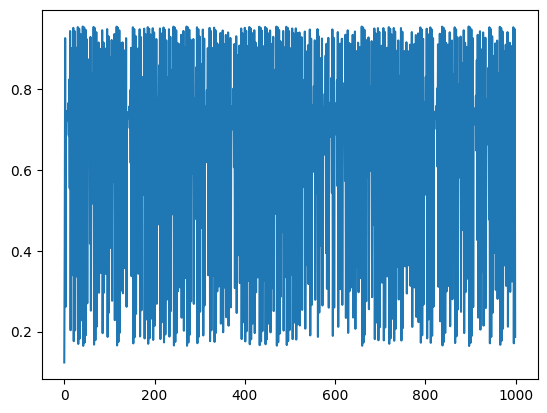

In [4]:
df = df["x"].values
df = df.reshape(-1,1)
df_scaled = df.astype("float32")
#今回は値が0~1だから正規化の必要なし
""" from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
df_scaled = scaler.fit_transform(df) """
print(df)
plt.plot(df_scaled)

In [5]:
train_size = int(len(df_scaled) * 0.70) #学習サイズ(144*0.7=100個)
test_size = len(df_scaled) - train_size #全データから学習サイズを引けばテストサイズになる
train = df_scaled[0:train_size,:] #全データから学習の個所を抜粋
test = df_scaled[train_size:len(df_scaled),:] #全データからテストの個所を抜粋
print("train size: {}, test size: {} ".format(len(train), len(test)))

train size: 700, test size: 300 


In [6]:
time_stemp = 10 #今回は10個のシーケンシャルデータを1固まりとするので10を設定
n_sample = train_size - time_stemp #学習予測サンプルはt=10~99なので90個

#シーケンシャルデータの固まり数、シーケンシャルデータの長さ、RNN_cellへの入力次元(1次元)に形を成形
input_data = np.zeros((n_sample, time_stemp, 1)) #シーケンシャルデータを格納する箱を用意(入力)
correct_input_data = np.zeros((n_sample, 1)) #シーケンシャルデータを格納する箱を用意(正解)

print(input_data.shape)
print(correct_input_data.shape)

(690, 10, 1)
(690, 1)


In [7]:
for i in range(n_sample):
    input_data[i] = df_scaled[i:i+time_stemp].reshape(-1, 1)
    correct_input_data[i] = df_scaled[i+time_stemp:i+time_stemp+1]

input_data = torch.tensor(input_data, dtype=torch.float) #Tensor化(入力)
correct_data = torch.tensor(correct_input_data, dtype=torch.float) #Tensor化(正解)
dataset = torch.utils.data.TensorDataset(input_data, correct_data) #データセット作成
train_loader = DataLoader(dataset, batch_size=4, shuffle=True) #データローダー作成

In [8]:
class My_rnn_net(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(My_rnn_net, self).__init__()

        self.input_size = input_size #入力データ(x)
        self.hidden_dim = hidden_dim #隠れ層データ(hidden)
        self.n_layers = n_layers #RNNを「上方向に」何層重ねるか？の設定 ※横方向ではない
        """
        PyTorchのRNNユニット。batch_first=Trueでバッチサイズを最初にくるように設定
         ※シーケンシャルデータと初期値のhiddenだけ入れてあげれば内部で勝手に計算してくれる
         ※出力部は各時刻毎に出力されるが、下で述べているように最後の時刻しか使用しない
        """
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size) #全結合層でhiddenからの出力を1個にする

    def forward(self, x):
        #h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).to(device)
        #y_rnn, h = self.rnn(x, h0)
        y_rnn, h = self.rnn(x, None) #hidden部分はコメントアウトした↑2行と同じ意味になっている。
        y = self.fc(y_rnn[:, -1, :]) #最後の時刻の出力だけを使用するので「-1」としている

        return y
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(in_features=hidden_layer_size, out_features=output_size)

    def forward(self, x):
        # LSTMのinputは(batch_size, seq_len, input_size)にする
        # LSTMのoutputは(batch_size, seq_len, hidden_layer_size)となる
        # hidden stateとcell stateにはNoneを渡して0ベクトルを渡す
        lstm_out, (hn, cn) = self.lstm(x, None)
        # Linearのinputは(N,∗,in_features)にする
        # lstm_out(batch_size, seq_len, hidden_layer_size)のseq_len方向の最後の値をLinearに入力する
        prediction = self.linear(lstm_out[:, -1, :])
        return prediction


#RNNの設定
n_inputs  = 1
n_outputs = 1   
n_hidden  = 150 #隠れ層(hidden)を 個に設定
n_layers  = 1

#net = My_rnn_net(n_inputs, n_outputs, n_hidden, n_layers) #RNNをインスタンス化
net = LSTM(n_inputs, n_hidden, n_outputs) #LSTMをインスタンス化

print(net) #作成したRNNの層を簡易表示

#おすすめのtorchinfoでさらに見やすく表示
batch_size = 8
summary(net, (batch_size, time_stemp, 1))


LSTM(
  (lstm): LSTM(1, 150, batch_first=True)
  (linear): Linear(in_features=150, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [8, 1]                    --
├─LSTM: 1-1                              [8, 10, 150]              91,800
├─Linear: 1-2                            [8, 1]                    151
Total params: 91,951
Trainable params: 91,951
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 7.35
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.37
Estimated Total Size (MB): 0.46

Epoch: 0 Loss_Train: 0.0818946077138444


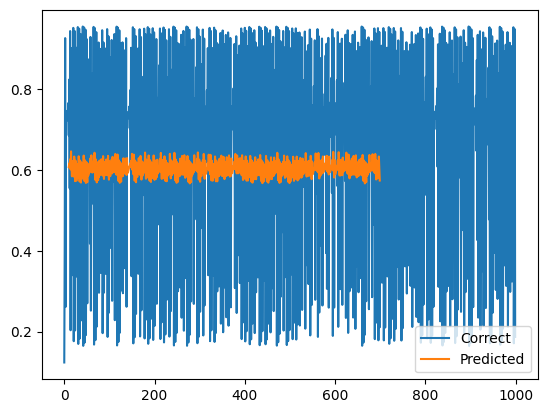

Epoch: 10 Loss_Train: 0.001101242651202483


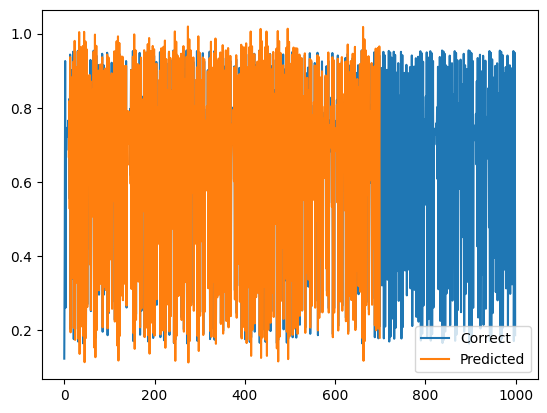

Epoch: 20 Loss_Train: 0.0006559899682048715


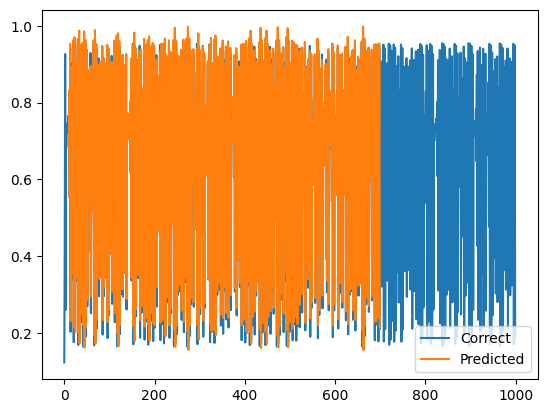

Epoch: 30 Loss_Train: 0.00039097961557593675


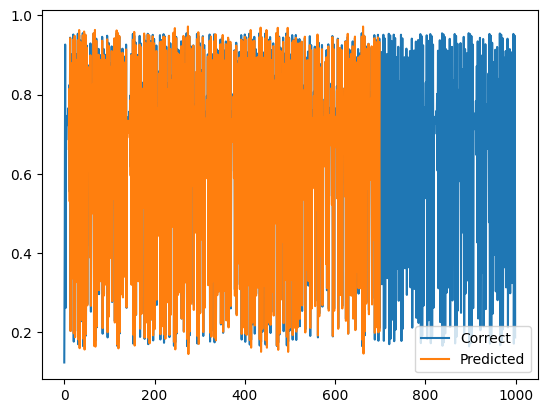

Epoch: 40 Loss_Train: 0.0001981353255785696


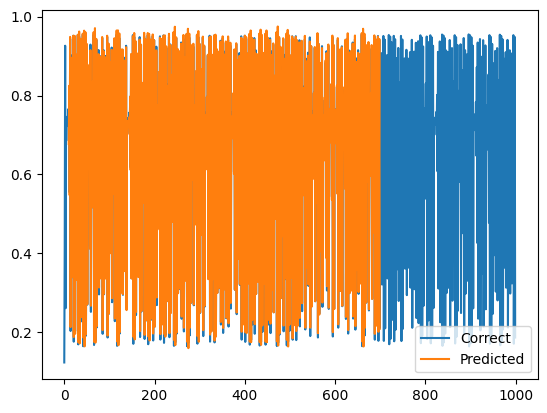

Epoch: 50 Loss_Train: 0.0001274676962902906


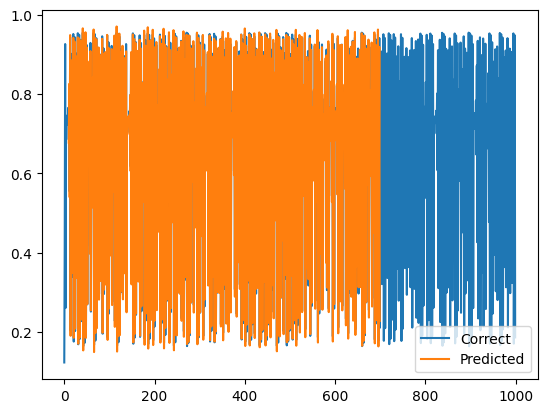

Epoch: 60 Loss_Train: 0.00010588364162854278


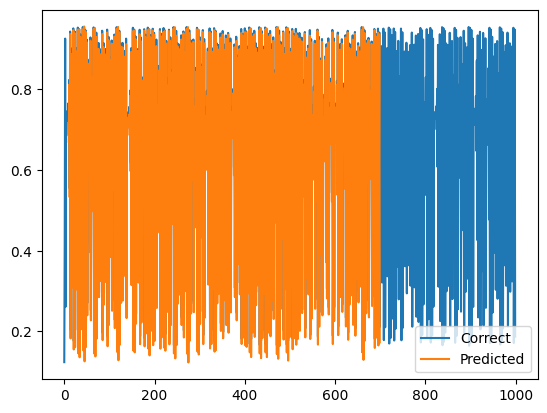

Epoch: 70 Loss_Train: 7.506721179307885e-05


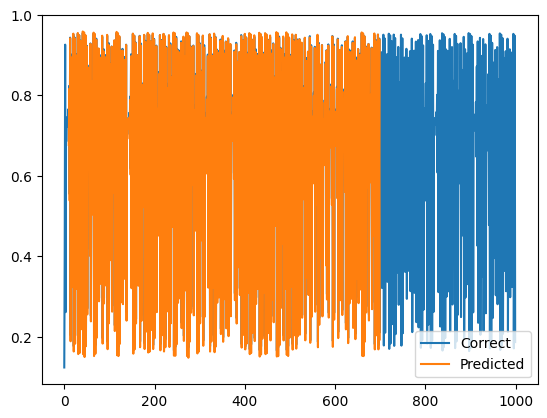

Epoch: 80 Loss_Train: 3.5786746661344264e-05


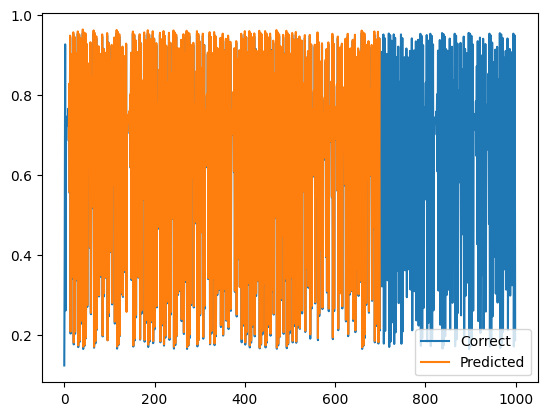

Epoch: 90 Loss_Train: 5.4287723413260255e-05


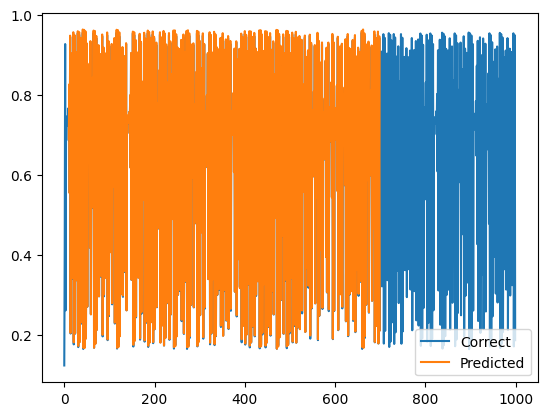

Epoch: 100 Loss_Train: 3.3781271265143846e-05


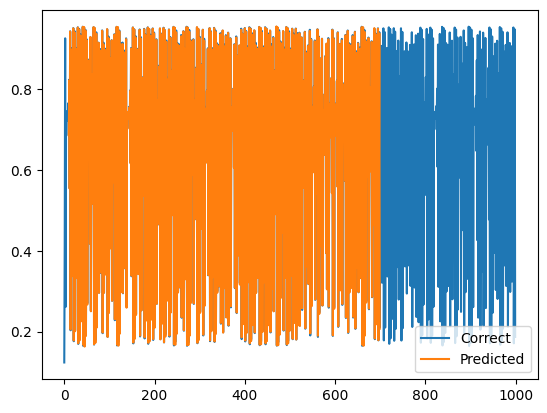

In [9]:
loss_fnc = nn.MSELoss() #損失関数はMSE
optimizer = optim.Adam(net.parameters(), lr=0.001) #オプティマイザはAdam
loss_record = [] #lossの推移記録用
device = torch.device("cuda:0" if torch.cuda. is_available() else "cpu")  #デバイス(GPU or CPU)設定 
epochs = 100 #エポック数

net.to(device) #モデルをGPU(CPU)へ

for i in range(epochs+1):
    net.train() #学習モード
    running_loss =0.0 #記録用loss初期化
    for j, (x, t) in enumerate(train_loader): #データローダからバッチ毎に取り出す #J：何個目のバッチか　X：J個目のバッチの入力データ　t：J個目のバッチの答えデータ
        x = x.to(device) #シーケンシャルデータをバッチサイズ分だけGPUへ
        optimizer.zero_grad() #勾配を初期化
        y = net(x) #RNNで予測
        y = y.to('cpu') #予測結果をCPUに戻す
        loss = loss_fnc(y, t) #MSEでloss計算
        loss.backward()  #逆伝番        
        optimizer.step()  #計算した勾配を用いて、全パラメータの値を更新する        
        running_loss += loss.item()  #バッチごとのlossを足していく
    running_loss /= j+1 #lossを平均化
    loss_record.append(running_loss) #記録用のlistにlossを加える

    """以下RNNの学習の経過を可視化するコード"""
    if i%10 == 0: #今回は100エポック毎に学習がどう進んだか？を表示させる
        print('Epoch:', i, 'Loss_Train:', running_loss)
        input_train = list(input_data[0].reshape(-1)) #まず最初にt(時間)＝0～9をlist化しておく
        predicted_train_plot = [] #学習結果plot用のlist
        net.eval() #予測モード
        for k in range(n_sample): #学習させる点の数だけループ
            x = torch.tensor(input_train[-time_stemp:]) #最新の10個のデータを取り出してTensor化
            x = x.reshape(1, time_stemp, 1) #予測なので当然バッチサイズは1
            x = x.to(device).float() #GPUへ
            y = net(x) #予測
            y = y.to('cpu') #結果をCPUへ戻す
            """
            もっと綺麗なやり方あるかもですが、次のループで値をずらす為の部分。
            t=0～9の予測が終了 ⇒ t=1～10で予測させたいのでt=10を追加する・・・を繰り返す
            """
            if k <= n_sample-2: 
                input_train.append(input_data[k+1][9].item())  #.itemでtensorの値を取得
            predicted_train_plot.append(y[0].item())

        plt.plot(range(len(df_scaled)), df_scaled, label='Correct')
        plt.plot(range(time_stemp, time_stemp+len(predicted_train_plot)), predicted_train_plot, label='Predicted')
        plt.legend()
        plt.show()


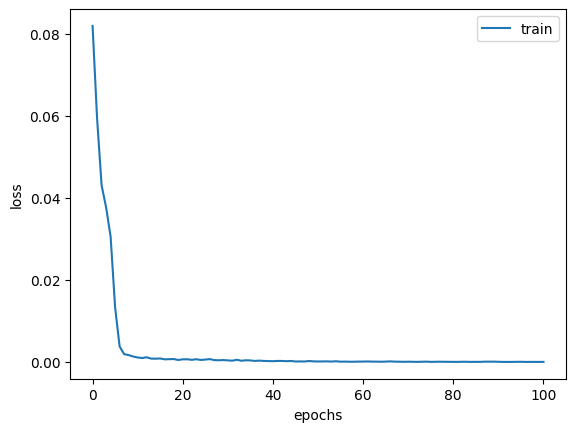

In [10]:
#最後にlossの推移を確認
plt.plot(range(len(loss_record)), loss_record, label='train')
plt.legend()

plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


#### 1点先予測

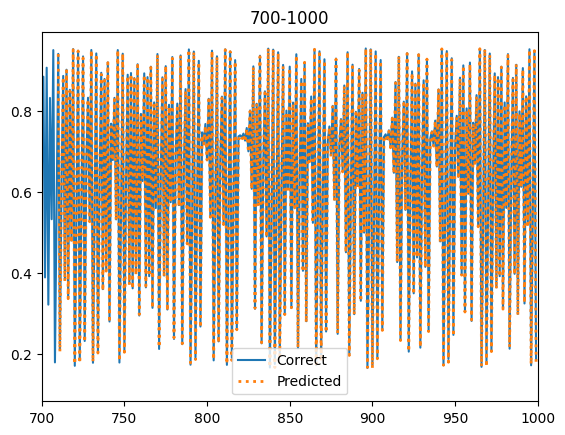

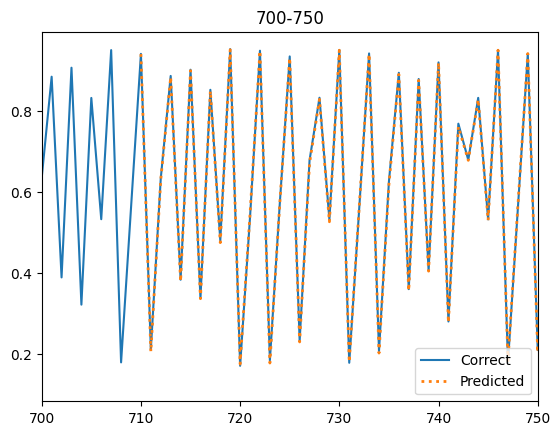

In [11]:
#学習の時と同じ感じでまずは空のデータを作る
time_stemp = 10
n_sample_test = len(df_scaled) - train_size - time_stemp#テストサイズは学習で使ってない部分
test_data = np.zeros((n_sample_test, time_stemp, 1))
correct_test_data = np.zeros((n_sample_test, 1))

#t=90以降のデータを抜粋してシーケンシャルデータとして格納していく
start_test = 700

for i in range(n_sample_test):
    test_data[i] = df_scaled[start_test+i : start_test+i+time_stemp].reshape(-1, 1)
    correct_test_data[i] = df_scaled[start_test+i+time_stemp : start_test+i+time_stemp+1]

#以下は学習と同じ要領
input_test = list(test_data[0].reshape(-1))
predicted_test_plot = []
net.eval()
for k in range(n_sample_test):
    x = torch.tensor(input_test[-time_stemp:])
    x = x.reshape(1, time_stemp, 1)
    x = x.to(device).float()
    y = net(x)
    y = y.to('cpu')
    if k <= n_sample_test-2: 
         input_test.append(test_data[k+1][9].item())
    predicted_test_plot.append(y[0].item())

plt.plot(range(len(df_scaled)), df_scaled, label='Correct')
plt.plot(range(start_test+time_stemp, start_test+time_stemp+len(predicted_test_plot)), predicted_test_plot , label='Predicted', linewidth=2, linestyle=":")
plt.xlim(700, 1000)
plt.legend()
plt.title("700-1000")
plt.show()
plt.close()
plt.plot(range(len(df_scaled)), df_scaled, label='Correct')
plt.plot(range(start_test+time_stemp, start_test+time_stemp+len(predicted_test_plot)), predicted_test_plot , label='Predicted', linewidth=2, linestyle=":")
plt.xlim(700, 750)
plt.legend()
plt.title("700-750")
plt.show()



#### 全体予測

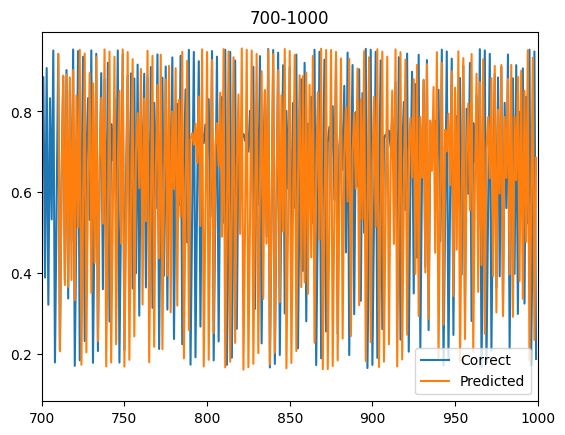

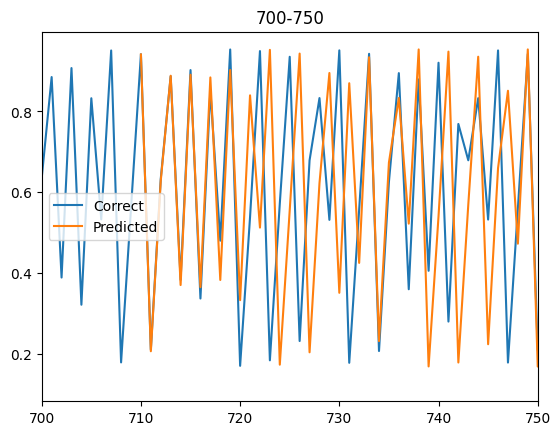

In [12]:
#学習の時と同じ感じでまずは空のデータを作る
time_stemp = 10
n_sample_test = len(df_scaled) - train_size - time_stemp#テストサイズは学習で使ってない部分
test_data = np.zeros((n_sample_test, time_stemp, 1))
correct_test_data = np.zeros((n_sample_test, 1))

#t=90以降のデータを抜粋してシーケンシャルデータとして格納していく
#n_sample_test =9
start_test = 700
for i in range(n_sample_test):
    test_data[i] = df_scaled[start_test+i : start_test+i+time_stemp].reshape(-1, 1)
    correct_test_data[i] = df_scaled[start_test+i+time_stemp : start_test+i+time_stemp+1]

#以下は学習と同じ要領
input_test = list(test_data[0].reshape(-1))
predicted_test_plot = []
net.eval()
for k in range(n_sample_test):
    x = torch.tensor(input_test[-time_stemp:])
    x = x.reshape(1, time_stemp, 1)
    x = x.to(device).float()
    y = net(x)
    y = y.to('cpu')
    if k <= n_sample_test-2: 
         input_test.append(y[0].item())
    predicted_test_plot.append(y[0].item())

plt.plot(range(len(df_scaled)), df_scaled, label='Correct')
plt.plot(range(start_test+time_stemp, start_test+time_stemp+len(predicted_test_plot)), predicted_test_plot , label='Predicted')
plt.xlim(700, 1000)
plt.legend()
plt.title("700-1000")
plt.show()
plt.close()
plt.plot(range(len(df_scaled)), df_scaled, label='Correct')
plt.plot(range(start_test+time_stemp, start_test+time_stemp+len(predicted_test_plot)), predicted_test_plot , label='Predicted')
plt.xlim(700, 750)
plt.legend()
plt.title("700-750")
plt.show()


バーストを確認  
バーストがあるa  
aの値によってどれだけ予測できるかを確認  
周期的、カオス  
分類(教師なし)  
3周期点p70  